In [1]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import itertools
from keras.backend import clear_session
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import keras
import gensim.downloader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

plt.style.use('ggplot')
#nltk.download('wordnet')
#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
df=pd.read_csv("data.txt",sep=";")
print(set(df["emotion"]))
dic={'anger':0, 'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}
df['emotion']=[*map(dic.get, df['emotion'])]

{'sadness', 'anger', 'fear', 'joy', 'love', 'surprise'}


In [3]:
def remove_symbols(sentence):
	symbols="""!"#$%&'()*+,،-./:;<=>1234567890؟?@[\]^_`{|}~"""
	for sym in symbols:
		sentence=sentence.replace(sym,"")
	return sentence

def lowercase(sentence):
	return sentence.lower()

lemmatizer=WordNetLemmatizer()
def lemmatize(sentence):
	return " ".join([lemmatizer.lemmatize(word) for word in sentence.split(" ")])

def remove_stopwords(sentence):
	return " ".join([word for word in sentence.split(" ") if word not in stop_words])

df.sentence=df.sentence.apply(remove_symbols)
df.sentence=df.sentence.apply(lowercase)
df.sentence=df.sentence.apply(remove_stopwords)
df.sentence=df.sentence.apply(lemmatize)

def normalize_sentence(sent):
	return lemmatize(remove_stopwords(lowercase(remove_symbols(sent))))

In [4]:
index = df[df.duplicated() == True].index
df.drop(index, axis = 0, inplace = True)
df.reset_index(inplace=True, drop = True)
index = df[df.sentence.duplicated() == True].index
df.drop(index, axis = 0, inplace = True)
df.reset_index(inplace=True, drop = True)

In [5]:
print(df[df.sentence.duplicated() == True])
print(df[df.duplicated() == True])

Empty DataFrame
Columns: [sentence, emotion]
Index: []
Empty DataFrame
Columns: [sentence, emotion]
Index: []


In [6]:
#remove short sentences?

#inds=[]
#for ind in range(df.shape[0]):
	#if len(df.sentence[ind].split())<3:
	#	inds.append(ind)
#df.drop(inds, axis = 0, inplace = True)
#df.reset_index(inplace=True, drop = True)

In [7]:
sentences_train, sentences_test, emotion_train, emotion_test=train_test_split(df["sentence"],df["emotion"],test_size=.25)
y_train=emotion_train
y_test=emotion_test
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([sentences_train, sentences_test], axis=0))
sequences_train=tokenizer.texts_to_sequences(sentences_train)
sequences_test=tokenizer.texts_to_sequences(sentences_test)
maxsentencelength=max([len(sent) for sent in df["sentence"]])
pad_sequences_train=pad_sequences(sequences_train,maxsentencelength)
pad_sequences_test=pad_sequences(sequences_test,maxsentencelength)
X_train=pad_sequences_train
X_test=pad_sequences_test

In [8]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')
dic_dim=len(tokenizer.word_index)
em_dim=len(glove_vectors["test"])

embedding_matrix=np.zeros((dic_dim+1,em_dim))

unk_count=0
unk_words=[]
unk_indices=[]
for word, i in tokenizer.word_index.items():
	try:
		embedding_matrix[i]=glove_vectors[word]
	except:
		unk_words.append(word)
		unk_count=unk_count+1
		unk_indices.append(i)
unk_indices=unk_indices[1:]
unk_words=unk_words[1:]

In [9]:
#Spellcheck!

#import textdistance
##spellchecked_indices=[np.argmin([textdistance.Jaccard(qval=2).distance(v,oov_word) for v in glove_vectors.index_to_key]) for oov_word in unk_words]
#spellchecked_indices=pd.read_csv("oov_indices.txt")
#spellchecked_indices=list(spellchecked_indices["0"])
#len(spellchecked_indices)
#spellchecked_words=[glove_vectors.index_to_key[ind] for ind in spellchecked_indices]
#for i in range(len(unk_indices)):
#	try:
#		embedding_matrix[unk_indices[i]]=glove_vectors[spellchecked_words[i]]
#	except:
#		pass

In [12]:
clear_session()
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)
model = Sequential()
model.add(layers.Embedding(dic_dim+1, em_dim, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(layers.Bidirectional(layers.LSTM(20, recurrent_dropout=.2,return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(10, recurrent_dropout=.2,return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(10, recurrent_dropout=.2)))
model.add(layers.Dense(6, activation='sigmoid'))

model.compile(loss="CategoricalCrossentropy", 
            optimizer=keras.optimizers.Adam(learning_rate=.001), 
            metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 229, 300)          4044000   
_________________________________________________________________
bidirectional (Bidirectional (None, 229, 40)           51360     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 229, 20)           4080      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20)                2480      
_________________________________________________________________
dense (Dense)                (None, 6)                 126       
Total params: 4,102,046
Trainable params: 58,046
Non-trainable params: 4,044,000
_________________________________________________________________


Epoch 1/200
239/239 [==============================] - 121s 447ms/step - loss: 1.5207 - accuracy: 0.3997 - val_loss: 1.1796 - val_accuracy: 0.5428
Epoch 2/200
239/239 [==============================] - 108s 453ms/step - loss: 1.0682 - accuracy: 0.6031 - val_loss: 0.8387 - val_accuracy: 0.7136
Epoch 3/200
239/239 [==============================] - 107s 449ms/step - loss: 0.7212 - accuracy: 0.7595 - val_loss: 0.6259 - val_accuracy: 0.7851
Epoch 4/200
239/239 [==============================] - 107s 446ms/step - loss: 0.5260 - accuracy: 0.8168 - val_loss: 0.5735 - val_accuracy: 0.7892
Epoch 5/200
239/239 [==============================] - 106s 443ms/step - loss: 0.4062 - accuracy: 0.8626 - val_loss: 0.4324 - val_accuracy: 0.8526
Epoch 6/200
239/239 [==============================] - 104s 437ms/step - loss: 0.2916 - accuracy: 0.9121 - val_loss: 0.4049 - val_accuracy: 0.8650
Epoch 7/200
239/239 [==============================] - 105s 440ms/step - loss: 0.2563 - accuracy: 0.9186 - val_loss: 0

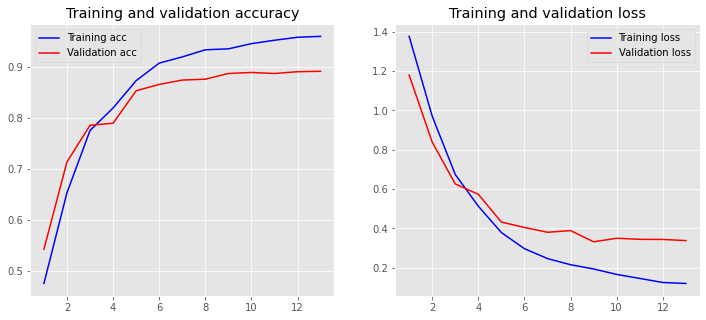

In [13]:

history = model.fit(X_train, y_train,
                    epochs=200,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=50,
                    callbacks=[callback]
                    )
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [14]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)
print(classification_report(emotion_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       534
           1       0.90      0.80      0.85       485
           2       0.89      0.93      0.91      1302
           3       0.81      0.81      0.81       343
           4       0.95      0.90      0.92      1156
           5       0.68      0.85      0.75       150

    accuracy                           0.89      3970
   macro avg       0.85      0.86      0.85      3970
weighted avg       0.89      0.89      0.89      3970

